# Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик.

**Задание 1:**
    
**сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.**


In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

Загрузка данных

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    return pd.read_csv(csv_path)

In [3]:
train = load_data("assignment_2_train.csv")
test = load_data("assignment_2_test.csv")

In [4]:
#Размерности датасетов
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [5]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [6]:
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [8]:
train["TransactionID"].nunique()

180000

Получение и обработка числовых признаков

In [5]:
numerical_features = train.select_dtypes(exclude=["object"])
print(f"count of numeric_features {numerical_features.shape[1]}")

count of numeric_features 380


In [6]:
numerical_features = numerical_features.drop(["TransactionID","TransactionDT", "isFraud"], axis=1)

In [7]:
#Заменяем пропуски на среднии
numerical_features = numerical_features.fillna(numerical_features.mean())

In [8]:
data=numerical_features

Получение и обработка категориальных признаков (кодировка с использованием OneHotEncoder)

In [17]:
from sklearn.preprocessing import OneHotEncoder

def handle_categorical_data(data, categorical_features):
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for col in categorical_features.columns:
        ohe_ftrs = enc.fit_transform(categorical_features[col].values.reshape(-1,1))
        tmp = pd.DataFrame(ohe_ftrs, columns = [col + '_' + str(i) for i in range(ohe_ftrs.shape[1])])
        data = pd.concat([data, tmp], axis=1)
    return data

In [9]:
categorical_features = train.select_dtypes(include=["object"])

In [10]:
print(f"count of categorical_features {categorical_features.shape[1]}")

count of categorical_features 14


In [20]:
data = handle_categorical_data(data, categorical_features)

In [21]:
data

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Анализ целевого признака

In [11]:
target=train['isFraud']

In [23]:
missing_values = target.copy().isnull().sum(axis=0)
missing_values

0

In [24]:
dataset_target = pd.DataFrame(train['isFraud'])
dataset_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 1 columns):
isFraud    180000 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [25]:
dataset_target.head(5)

,isFraud
0,0
1,0
2,0
3,0
4,0


In [26]:
values_count_isFraud_0 = dataset_target[dataset_target["isFraud"]==0].count()["isFraud"]
values_count_isFraud_1 = dataset_target[dataset_target["isFraud"]==1].count()["isFraud"]
values_count_isFraud_1_2 = np.around(values_count_isFraud_1/values_count_isFraud_0,3)
values_count_isFraud_Sum = values_count_isFraud_0+values_count_isFraud_1
print("isFraud==0 values count =",values_count_isFraud_0)
print("isFraud==1 values count =",values_count_isFraud_1)
print("(isFraud==1)count / (isFraud==0)count values count =",values_count_isFraud_1_2)
print("isFraud==0 and isFraud==1 in sum values count =",values_count_isFraud_Sum)

isFraud==0 values count = 174859
isFraud==1 values count = 5141
(isFraud==1)count / (isFraud==0)count values count = 0.029
isFraud==0 and isFraud==1 in sum values count = 180000


Тренировка модели где используется Hold-Out валидация (валидация на отложенной выборке)

Hold-Out валидация (валидация на отложенной выборке) - train делим на 2 выборки - тренировочную и валидационную

In [27]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 541 cols
x_valid.shape = 36000 rows, 541 cols


In [28]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
valid_scores = pd.DataFrame({"isFraud": y_valid})
test_scores = pd.DataFrame({"isFraud": test["isFraud"]})

Тренировка LGBM модели

In [29]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 8,
    "seed": 27,
    "early_stopping_rounds":300
}

In [30]:
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=300,
    eval_metric="auc",
    verbose=500,
    categorical_feature="auto"
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=300, early_stopping_rounds=300 will be ignored. Current value: early_stopping_round=300
[500]	training's auc: 0.949848	valid_1's auc: 0.929009
[1000]	training's auc: 0.970264	valid_1's auc: 0.941172
[1500]	training's auc: 0.980284	valid_1's auc: 0.946948
[2000]	training's auc: 0.986377	valid_1's auc: 0.950109
[2500]	training's auc: 0.990329	valid_1's auc: 0.952416
[3000]	training's auc: 0.993173	valid_1's auc: 0.953981
[3500]	training's auc: 0.994769	valid_1's auc: 0.955224
[4000]	training's auc: 0.99619	valid_1's auc: 0.956112
[4500]	training's auc: 0.997254	valid_1's auc: 0.956433
[5000]	training's auc: 0.997947	valid_1's auc: 0.956899
[5500]	training's auc: 0.998555	valid_1's auc: 0.957467
[6000]	training's auc: 0.998878	valid_1's auc: 0.957939
[6500]	training's auc: 0.999114	valid_1's auc: 0.958834
[7000]	training's auc: 0.999339	valid_1's auc: 0.959014
[7500]	training's auc: 0.999471	valid_1's auc: 0.959168
[8000]	training's auc: 0.

LGBMClassifier(early_stopping_rounds=300, learning_rate=0.01, metric='auc',
               n_estimators=10000, n_jobs=8, objective='binary', seed=27)

In [31]:
train_scores["LGBM_gbtree"] = model_lgb.predict_proba(x_train)[:,1]
valid_scores["LGBM_gbtree"] = model_lgb.predict_proba(x_valid)[:,1]

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

In [26]:
def plot_curves(valid_scores_par: pd.DataFrame, train_scores_par: pd.DataFrame,target_name ) -> None:
    """
    Построение ROC-Curve для множества построенных моделей.

    Parameters
    ----------
    valid_scores: pandas.core.frame.DataFrame
        Датафрем с прогнозами модели на валидационной выборке.

    train_scores: pandas.core.frame.DataFrame
        Датафрейм с прогнозами модели на обучающей выборке.

    """
    fig = plt.figure(figsize=(15, 5))
    columns = set(valid_scores_par.columns) - set([target_name])

    plt.subplot(121)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Train ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            train_scores_par[target_name], train_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)

    plt.legend(loc="best")

    plt.subplot(122)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Valid ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            valid_scores_par[target_name], valid_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)
    plt.legend(loc="best")

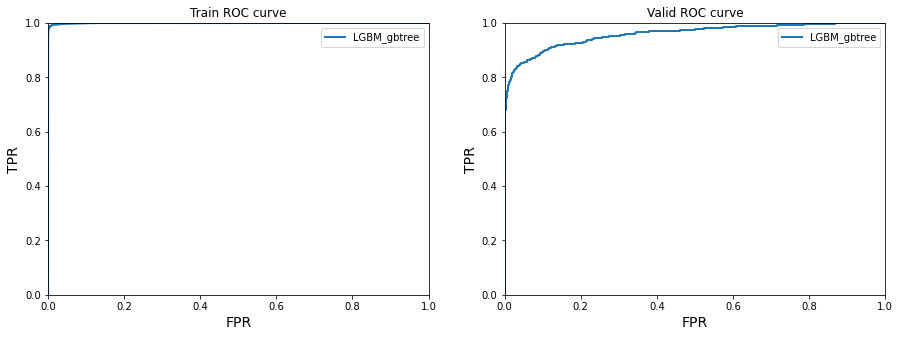

In [34]:
plot_curves(valid_scores, train_scores,"isFraud")

Обработка признаков теста

In [35]:
test

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.000,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.000,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,0,7415081,319.950,W,13844,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3287003,0,7415111,171.000,W,11556,309.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3287004,0,7415112,107.950,W,10985,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,3386996,0,10091528,368.990,W,13964,496.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,3386997,0,10091533,445.330,W,10616,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,3386998,0,10091544,15.226,C,9803,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99999,3386999,0,10091549,34.742,C,16062,500.0,185.0,mastercard,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
test_numerical_features = test.select_dtypes(exclude=["object"])
print(f"count of numeric_features {test_numerical_features.shape[1]}")


count of numeric_features 380


In [37]:
#Получение и обработка числовых признаков
test_numerical_features = test_numerical_features.drop(["TransactionID","TransactionDT","isFraud"], axis=1)
#Заменяем пропуски на среднии
test_numerical_features = test_numerical_features.fillna(test_numerical_features.mean())
test_data=test_numerical_features

#Получение и обработка категориальных признаков
test_categorical_features = test.select_dtypes(include=["object"])
test_data = handle_categorical_data(test_data, test_categorical_features)

#Получение и обработка целевого признака
test_target=test['isFraud']

In [38]:
test_scores = pd.DataFrame({"isFraud": test_target}) 


In [39]:
test_data.shape

(100001, 537)

In [40]:
x_valid.shape

(36000, 541)

In [41]:
train_not_test = data.columns.difference(test_data.columns)
train_not_test.tolist()

['R_emaildomain_57',
 'R_emaildomain_58',
 'R_emaildomain_59',
 'R_emaildomain_60']

In [42]:
for col in train_not_test.tolist():
    test_data[col]=0.0

In [43]:
test_scores["LGBM_gbtree"] = model_lgb.predict_proba(test_data)[:,1]

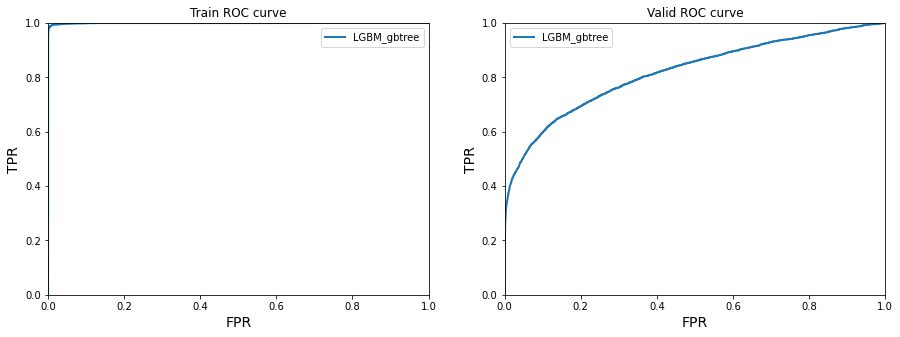

In [44]:
plot_curves(test_scores,train_scores,"isFraud")

In [45]:
train_predict_target=model_lgb.predict(x_train)
train_roc_auc=roc_auc_score(y_train,train_predict_target)
train_roc_auc


0.9439406635254896

In [48]:
valid_predict_target=model_lgb.predict(x_valid)
valid_roc_auc=roc_auc_score(y_valid,valid_predict_target)
valid_roc_auc

0.8014390386037458

In [46]:
test_predict_target=model_lgb.predict(test_data)

In [47]:
test_roc_auc=roc_auc_score(test["isFraud"].tolist(),test_predict_target)
test_roc_auc

0.578651248953539

Выводы: качество модели на валидационной выборке достаточно хорошее, roc-auc=0.96.  
Расхождение по сравнению с качеством на обучающей выборке -на валидационной выборке заметное, тут видно переобучение на обучающей выборке.Оценить качество на ЛБ - не очень большое, сравнить с качеством на обучении и валидации - видно большое переобучение на тренировочной выборке - возможно надо выбрать другую модель

Возьмем CatBoost  модель

In [147]:
cb_params = {
    "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [12]:
categorical_features=categorical_features.fillna('')

In [13]:
data = pd.concat([numerical_features, categorical_features], axis=1)

In [150]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 391 cols
x_valid.shape = 36000 rows, 391 cols


In [14]:
cat_feats =[]
for col in categorical_features.columns:
    cat_feats.append(col)
cat_feats

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [169]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
valid_scores = pd.DataFrame({"isFraud": y_valid})

Тренировка CatBoost модели

In [154]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5788717	test1: 0.5732932	best: 0.5732932 (0)	total: 498ms	remaining: 24m 53s
300:	test: 0.8949634	test1: 0.8863130	best: 0.8863130 (300)	total: 1m 6s	remaining: 9m 55s
600:	test: 0.9050738	test1: 0.8954457	best: 0.8954457 (600)	total: 2m 12s	remaining: 8m 48s
900:	test: 0.9103720	test1: 0.9003304	best: 0.9003305 (899)	total: 3m 23s	remaining: 7m 53s
1200:	test: 0.9132663	test1: 0.9026436	best: 0.9026443 (1198)	total: 4m 37s	remaining: 6m 56s
1500:	test: 0.9159531	test1: 0.9047943	best: 0.9047978 (1494)	total: 5m 53s	remaining: 5m 53s
1800:	test: 0.9184810	test1: 0.9066970	best: 0.9067316 (1781)	total: 7m 10s	remaining: 4m 46s
2100:	test: 0.9218551	test1: 0.9095639	best: 0.9095639 (2100)	total: 8m 30s	remaining: 3m 38s
2400:	test: 0.9237765	test1: 0.9110825	best: 0.9110826 (2399)	total: 9m 51s	remaining: 2m 27s
2700:	test: 0.9262156	test1: 0.9131517	best: 0.9131517 (2700)	total: 11m 11s	remaining: 1m 14s
2999:	test: 0.9278337	test1: 0.9144433	best: 0.9144481 (2996)	total: 12m

In [170]:
train_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_valid)[:,1]

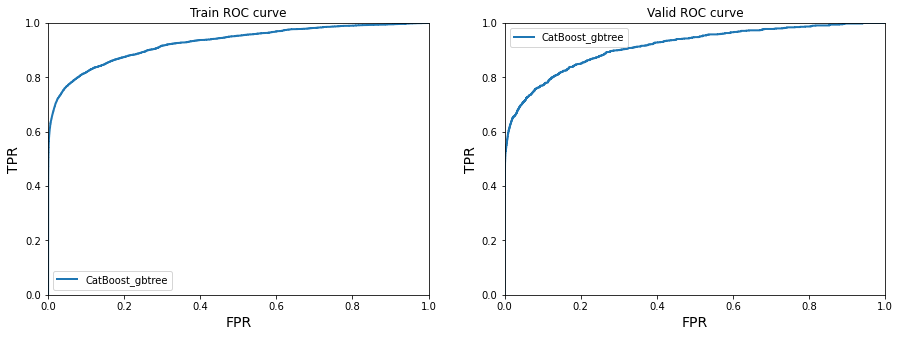

In [171]:
plot_curves(valid_scores, train_scores,"isFraud")

In [200]:
test_numerical_features = test.select_dtypes(exclude=["object"])
print(f"count of numeric_features {test_numerical_features.shape[1]}")
test_numerical_features = test_numerical_features.drop(["TransactionID","TransactionDT","isFraud"], axis=1)
test_categorical_features = test.select_dtypes(include=["object"])
test_categorical_features=test_categorical_features.fillna('')

count of numeric_features 380


In [201]:
test_numerical_features = test_numerical_features.fillna(test_numerical_features.mean())

In [202]:
test_data = pd.concat([test_numerical_features, test_categorical_features], axis=1)

In [203]:
test_scores = pd.DataFrame({"isFraud": test["isFraud"]}) 

In [204]:
test_scores["CatBoost_gbtree"] = model_cb.predict_proba(test_data)[:,1]

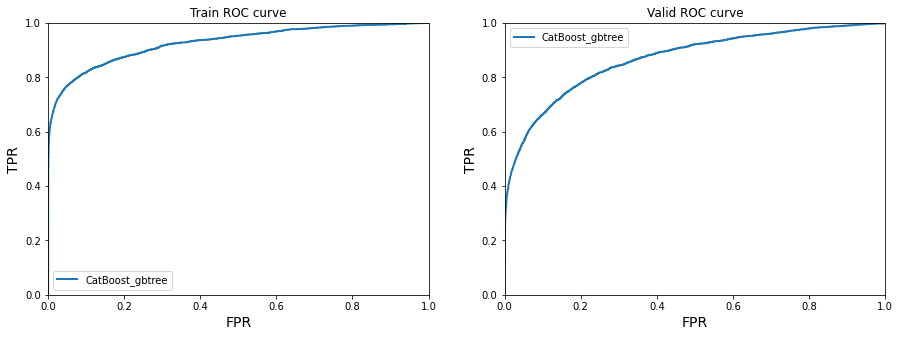

In [205]:
plot_curves(test_scores,train_scores,"isFraud")

In [206]:
test_predict_target=model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isFraud"].tolist(),test_predict_target)
test_roc_auc

0.6396731650515586

Выводы: CatBoost модель гораздо лучше показывает показатель roc-auc на тестовой выборке - ЛБ и при этом меньше переобучается на валидационной и тестовой выборке по сравнению с обучающей выборкой.
Качество модели на валидационной выборке - приемлемое, расхождение по сравнению с качеством на обучающей выборке и валидационной выборке - не сильное - почти нет переобучения. Качество на ЛБ, в сравнении с качеством на обучении и валидации - хуже, но все же лучше чем модель LGBM

**Задание 2:**

**сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.**

Возьмем CatBoost  модель

Будем менять n_estimators и max_depth и l2_leaf_reg

1) "n_estimators": 3000;  "max_depth": 4; "l2_leaf_reg": 100

In [10]:
cb_params = {
    "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [11]:
categorical_features=categorical_features.fillna('')

In [12]:
data = pd.concat([numerical_features, categorical_features], axis=1)

In [21]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=1
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 391 cols
x_valid.shape = 37800 rows, 391 cols
x_test.shape = 16201 rows, 391 cols


In [17]:
cat_feats =[]
for col in categorical_features.columns:
    cat_feats.append(col)
cat_feats

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [24]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
valid_scores = pd.DataFrame({"isFraud": y_valid})
test_scores = pd.DataFrame({"isFraud": y_test})

In [23]:
LB_test_scores = pd.DataFrame({"isFraud": test["isFraud"]}) 

In [22]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5358912	test1: 0.5329285	best: 0.5329285 (0)	total: 426ms	remaining: 21m 18s
300:	test: 0.8884480	test1: 0.8837647	best: 0.8837647 (300)	total: 39.1s	remaining: 5m 50s
600:	test: 0.8955137	test1: 0.8894216	best: 0.8894216 (600)	total: 1m 14s	remaining: 4m 59s
900:	test: 0.8996764	test1: 0.8929282	best: 0.8929282 (899)	total: 1m 55s	remaining: 4m 29s
1200:	test: 0.9023343	test1: 0.8947951	best: 0.8948080 (1190)	total: 2m 37s	remaining: 3m 56s
1500:	test: 0.9044680	test1: 0.8965704	best: 0.8965822 (1495)	total: 3m 18s	remaining: 3m 18s
1800:	test: 0.9086767	test1: 0.9002840	best: 0.9002846 (1788)	total: 4m 1s	remaining: 2m 40s
2100:	test: 0.9108635	test1: 0.9021935	best: 0.9021940 (2098)	total: 4m 46s	remaining: 2m 2s
2400:	test: 0.9127130	test1: 0.9036452	best: 0.9036464 (2394)	total: 5m 33s	remaining: 1m 23s
2700:	test: 0.9133077	test1: 0.9041289	best: 0.9041436 (2697)	total: 6m 20s	remaining: 42.1s
2999:	test: 0.9141695	test1: 0.9047356	best: 0.9047382 (2970)	total: 7m 8s	r

In [26]:
model_cb_1=model_cb

In [27]:
train_scores["CatBoost_gbtree_1"] = model_cb_1.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_1"] = model_cb_1.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree_1"] = model_cb_1.predict_proba(x_test)[:,1]

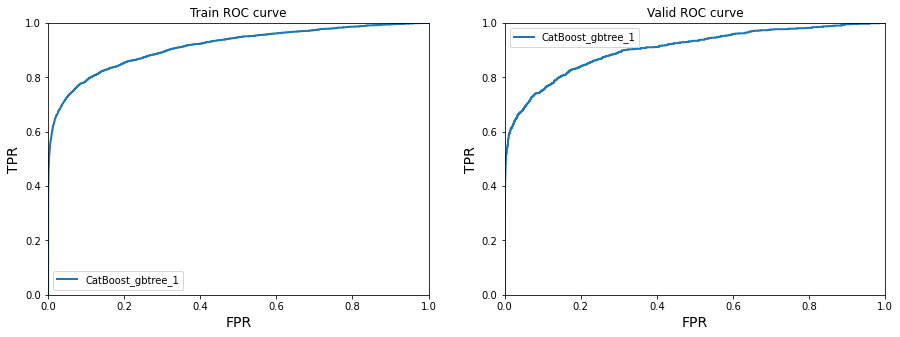

In [32]:
plot_curves(valid_scores, train_scores,"isFraud")

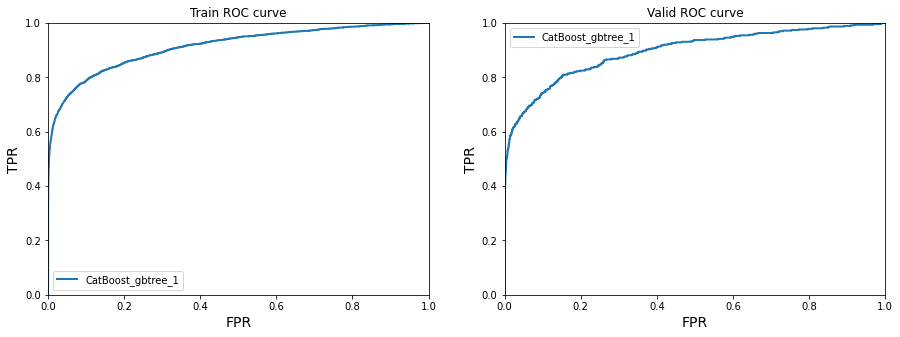

In [33]:
plot_curves(test_scores, train_scores,"isFraud")

In [34]:
test_predict_target=model_cb_1.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.6905410739081399

2) "n_estimators": 4000;  "max_depth": 7; "l2_leaf_reg": 100

In [19]:
cb_params = {
    "n_estimators": 4000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 7,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [22]:
model_cb_2 = cb.CatBoostClassifier(**cb_params)
model_cb_2.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6349778	test1: 0.6269278	best: 0.6269278 (0)	total: 550ms	remaining: 36m 39s
300:	test: 0.8990770	test1: 0.8917127	best: 0.8917271 (295)	total: 1m 10s	remaining: 14m 27s
600:	test: 0.9101769	test1: 0.8990980	best: 0.8990980 (600)	total: 2m 20s	remaining: 13m 17s
900:	test: 0.9132293	test1: 0.9013615	best: 0.9013634 (898)	total: 3m 31s	remaining: 12m 8s
1200:	test: 0.9170927	test1: 0.9043027	best: 0.9043027 (1200)	total: 4m 47s	remaining: 11m 10s
1500:	test: 0.9195193	test1: 0.9061100	best: 0.9061389 (1496)	total: 6m	remaining: 10m
1800:	test: 0.9223263	test1: 0.9088710	best: 0.9088710 (1800)	total: 7m 15s	remaining: 8m 51s
2100:	test: 0.9256699	test1: 0.9115235	best: 0.9115324 (2092)	total: 8m 30s	remaining: 7m 41s
2400:	test: 0.9284221	test1: 0.9137043	best: 0.9137043 (2400)	total: 9m 46s	remaining: 6m 30s
2700:	test: 0.9314666	test1: 0.9160632	best: 0.9160710 (2696)	total: 11m 4s	remaining: 5m 19s
3000:	test: 0.9335879	test1: 0.9176421	best: 0.9176421 (3000)	total: 12m 22s

In [24]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
valid_scores = pd.DataFrame({"isFraud": y_valid})
test_scores = pd.DataFrame({"isFraud": y_test})

train_scores["CatBoost_gbtree_2"] = model_cb_2.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_2"] = model_cb_2.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree_2"] = model_cb_2.predict_proba(x_test)[:,1]

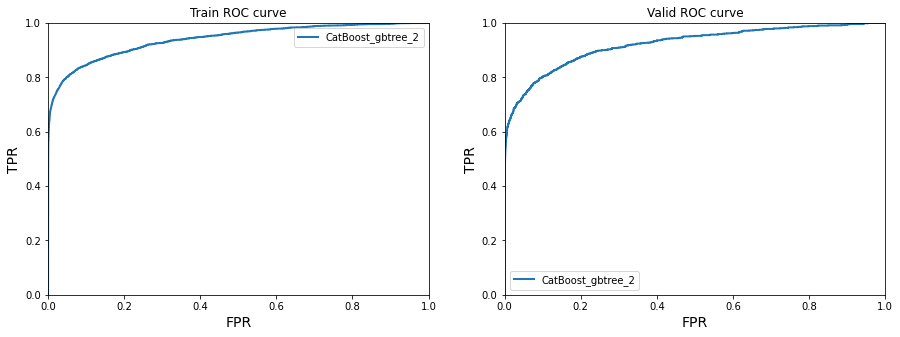

In [29]:
plot_curves(valid_scores, train_scores,"isFraud")

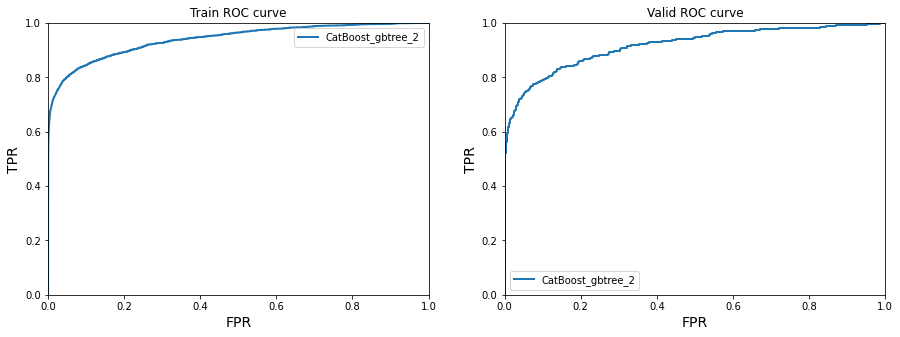

In [30]:
plot_curves(test_scores, train_scores,"isFraud")

In [31]:
test_predict_target=model_cb_2.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.734881072266792

3) "n_estimators": 3000;  "max_depth": 6; "l2_leaf_reg": 200

In [41]:
cb_params = {
    "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 6,
    "l2_leaf_reg": 200,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [42]:
model_cb_3 = cb.CatBoostClassifier(**cb_params)
model_cb_3.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5359848	test1: 0.5324727	best: 0.5324727 (0)	total: 200ms	remaining: 10m
300:	test: 0.8916511	test1: 0.8855204	best: 0.8855204 (300)	total: 1m	remaining: 8m 59s
600:	test: 0.9008011	test1: 0.8937014	best: 0.8937014 (600)	total: 2m 6s	remaining: 8m 26s
900:	test: 0.9045175	test1: 0.8964363	best: 0.8964379 (890)	total: 3m 21s	remaining: 7m 49s
1200:	test: 0.9065555	test1: 0.8977473	best: 0.8977473 (1200)	total: 4m 40s	remaining: 6m 59s
1500:	test: 0.9091298	test1: 0.8997417	best: 0.8997417 (1500)	total: 6m 24s	remaining: 6m 23s
1800:	test: 0.9110801	test1: 0.9012360	best: 0.9012360 (1800)	total: 7m 45s	remaining: 5m 9s
2100:	test: 0.9129514	test1: 0.9025290	best: 0.9025290 (2100)	total: 8m 58s	remaining: 3m 50s
2400:	test: 0.9155907	test1: 0.9046990	best: 0.9046990 (2400)	total: 10m 11s	remaining: 2m 32s
2700:	test: 0.9167418	test1: 0.9052332	best: 0.9052357 (2684)	total: 11m 25s	remaining: 1m 15s
2999:	test: 0.9176889	test1: 0.9059033	best: 0.9059110 (2992)	total: 12m 37s	rem

In [43]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
valid_scores = pd.DataFrame({"isFraud": y_valid})
test_scores = pd.DataFrame({"isFraud": y_test})

train_scores["CatBoost_gbtree_3"] = model_cb_3.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_3"] = model_cb_3.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree_3"] = model_cb_3.predict_proba(x_test)[:,1]

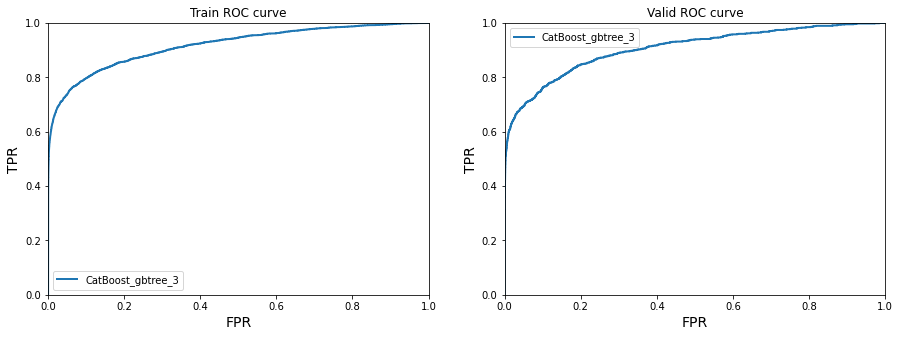

In [44]:
plot_curves(valid_scores, train_scores,"isFraud")

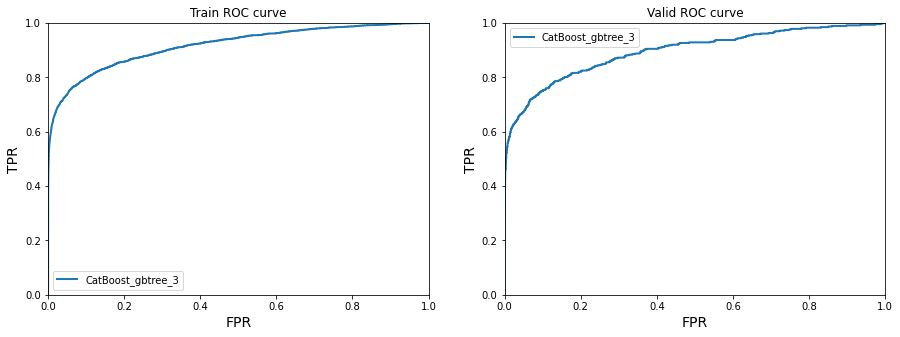

In [45]:
plot_curves(test_scores, train_scores,"isFraud")

In [46]:
test_predict_target=model_cb_3.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.7046117210356302

In [32]:
#Лучшая модель - 2 модель
best_model_cb=model_cb_2

In [33]:
train_scores = pd.DataFrame({"isFraud": y_train}) 

In [34]:
train_scores["CatBoost_gbtree_Best"]=model_cb_2.predict_proba(x_train)[:,1]

Анализ на тесте

In [35]:
test_numerical_features = test.select_dtypes(exclude=["object"])
test_numerical_features = test_numerical_features.drop(["TransactionID","TransactionDT","isFraud"], axis=1)
test_numerical_features = test_numerical_features.fillna(test_numerical_features.mean())

test_categorical_features = test.select_dtypes(include=["object"])
test_categorical_features=test_categorical_features.fillna('')

test_data = pd.concat([test_numerical_features, test_categorical_features], axis=1)

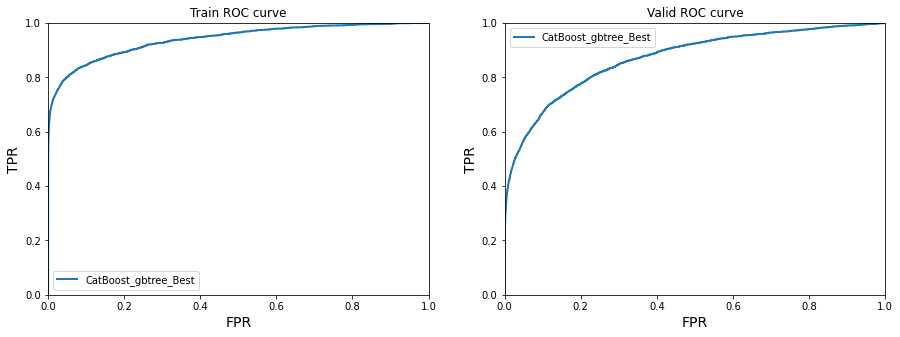

In [36]:
LB_test_scores["CatBoost_gbtree_Best"] = best_model_cb.predict_proba(test_data)[:,1]
plot_curves(LB_test_scores,train_scores,"isFraud")

In [37]:
test_predict_target=best_model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isFraud"].tolist(),test_predict_target)
test_roc_auc

0.641644773884366

Вывод: результат немного лучше чем при разбиении на 2 поднабора.
Качество модели на валидационной выборке - приемлемое, расхождение по сравнению с качеством на обучающей выборке и валидационной выборке - не сильное - почти нет переобучения. Качество на ЛБ, в сравнении с качеством на обучении и валидации - хуже, есть переобучение

**Задание 3:**

**построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.**

Из-за огромности задания оставшаяся часть будет сделана и добавлена позже.

In [16]:
from tqdm import tqdm
from typing import List, Tuple

In [17]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

строим доверительный интервал на выделенном тесте (3 часть обучаемой выборки)

In [42]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, best_model_cb.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.7122632824018443, 0.7582786454781156)

строим доверительный интервал на тесте ЛБ 

In [44]:
np.random.seed(27)
scores = create_bootstrap_metrics(test["isFraud"], test_predict_target, roc_auc_score)

calculate_confidence_interval(scores)

(0.6342742359953468, 0.6488857218908691)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'sampel number')

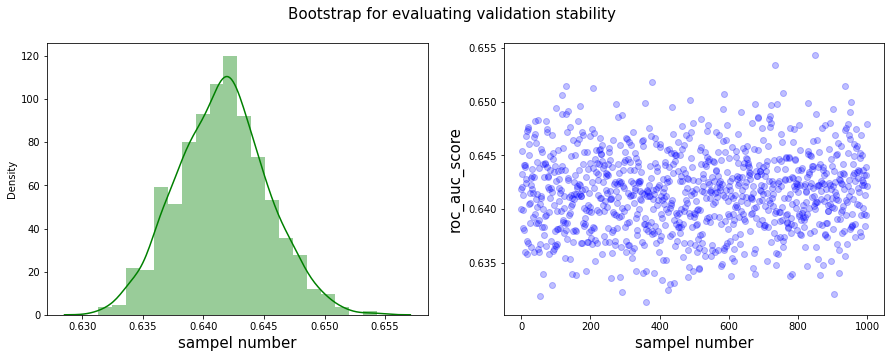

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("roc_auc_score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

In [46]:
confidence_interval_width = 0.64888-0.63427
confidence_interval_width

0.014610000000000012

Выводы ширина доверительного интервала достаточно узкая и приемлемая (roc_auc_score с равной вероятностью принимает значения внутри данного доверительного интервала), что говорит об устойчивости валидации.

**Задание 4:**

**выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.**

In [47]:
x_adv = pd.concat([
    data, test_data], axis=0
)
y_adv = np.hstack((np.zeros(data.shape[0]), np.ones(test_data.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [52]:
cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 7,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [53]:
model_cb_2.fit(x_adv, 
             y_adv,    
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6420305	test1: 0.6554981	best: 0.6554981 (0)	total: 409ms	remaining: 27m 16s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6880835489
bestIteration = 16

Shrink model to first 17 iterations.


In [54]:
y_pred_adv = model_cb_2.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


Вывод - данные тренировочные отличаются очень сильно от тестовых

In [56]:
#тренировочные данные
y_pred = model_cb_2.predict_proba(data)
y_pred

array([[0.99192824, 0.00807176],
       [0.99231074, 0.00768926],
       [0.9920858 , 0.0079142 ],
       ...,
       [0.9920858 , 0.0079142 ],
       [0.99215763, 0.00784237],
       [0.9920858 , 0.0079142 ]])

In [57]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    179887
(0.1, 0.2]       111
(0.2, 0.3]         2
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

Берем в качестве валидационных данных данные в диапазонах бинов начиная с 0.6, они  похожи на данные из тестового набора

In [75]:
train_max_idx=180000*0.6
int(train_max_idx)

108000

In [79]:
x_train, x_valid = train_test_split(
    data, train_size=0.6, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.6, random_state=1
)

x_valid=data[int(train_max_idx):]
y_valid = target[int(train_max_idx):]



In [80]:
cb_params = {
    "n_estimators": 4000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 7,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [81]:
model_cb_2 = cb.CatBoostClassifier(**cb_params)
model_cb_2.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6938076	test1: 0.6667659	best: 0.6667659 (0)	total: 224ms	remaining: 14m 56s
300:	test: 0.9005094	test1: 0.8906896	best: 0.8906896 (300)	total: 1m 9s	remaining: 14m 16s
600:	test: 0.9124523	test1: 0.9012716	best: 0.9012716 (600)	total: 2m 30s	remaining: 14m 11s
900:	test: 0.9167929	test1: 0.9052768	best: 0.9052807 (898)	total: 3m 57s	remaining: 13m 36s
1200:	test: 0.9193633	test1: 0.9074284	best: 0.9074284 (1200)	total: 5m 20s	remaining: 12m 26s
1500:	test: 0.9220294	test1: 0.9097383	best: 0.9097390 (1499)	total: 6m 43s	remaining: 11m 12s
1800:	test: 0.9253322	test1: 0.9135206	best: 0.9135206 (1799)	total: 8m 12s	remaining: 10m
2100:	test: 0.9279009	test1: 0.9160006	best: 0.9160026 (2099)	total: 9m 41s	remaining: 8m 45s
2400:	test: 0.9300176	test1: 0.9184939	best: 0.9185201 (2392)	total: 11m 12s	remaining: 7m 27s
2700:	test: 0.9319238	test1: 0.9206744	best: 0.9206744 (2700)	total: 12m 43s	remaining: 6m 7s
3000:	test: 0.9343471	test1: 0.9239228	best: 0.9239228 (3000)	total: 1

In [82]:
best_model_cb=model_cb_2

In [83]:
train_scores = pd.DataFrame({"isFraud": y_train}) 
train_scores["CatBoost_adv_Best"]=best_model_cb.predict_proba(x_train)[:,1]


In [84]:
LB_test_scores = pd.DataFrame({"isFraud": test["isFraud"]}) 
LB_test_scores["CatBoost_adv_Best"] = best_model_cb.predict_proba(test_data)[:,1]


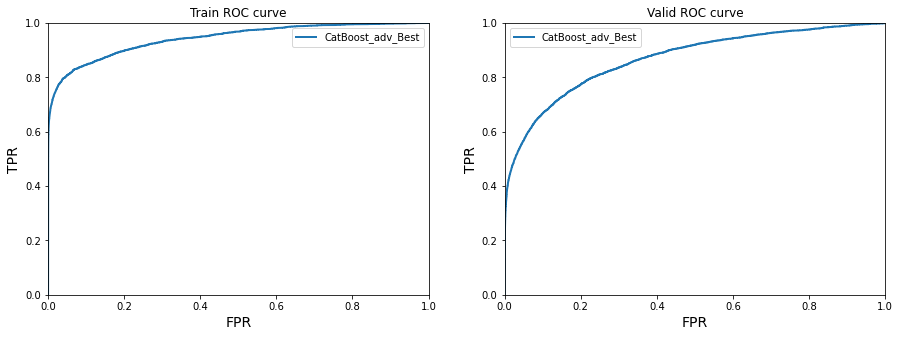

In [85]:
plot_curves(LB_test_scores,train_scores,"isFraud")

In [86]:
test_predict_target=best_model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isFraud"].tolist(),test_predict_target)
test_roc_auc

0.6424074290810544

Вывод - улучшения незначительные - в 3 знаке только

**Задание 5:**

**сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.**